# Where could you build ADUs in Waltham before the rezoning?


In [1]:
import pandas as pd
import geopandas as geo_pd

from data.connect_db import get_db
from waltham.constants import SQ_FT_PER_ACRE

con = get_db()

In [2]:
# get data used below

query = "select * from \"M308Assess_CY22_FY23\""
tax_df = pd.read_sql(query, con)
tax_df.drop(columns=["TOWN_ID", "id"], inplace=True)

query = "select * from \"M308TaxPar_CY22_FY23\""
geo_df = geo_pd.read_postgis(query, con)
geo_df.drop(columns=["TOWN_ID", "id"], inplace=True)

owners_df = pd.read_csv("likely_homeowners.csv")
owners_df = owners_df[["PROP_ID", "OWNER_OCCUPIED"]]

query = "select * from \"Buildings\""
buildings_df = geo_pd.read_postgis(query, con)
buildings_df = buildings_df[["geom", "TYPE", "YearBuilt"]]

query = "select * from \"WalthamZoning\""
zones_df = geo_pd.read_postgis(query, con)

In [3]:
# merge/geometric join, and cleanup

df = tax_df.merge(owners_df, on="PROP_ID")

geo_df = geo_df.sjoin(zones_df)
geo_df.drop(columns="index_right", inplace=True)

df = geo_df.merge(df, on="LOC_ID")

# value here is in acres, code uses square feet
df["LOT_SIZE"] = df["LOT_SIZE"].apply(lambda x: x * SQ_FT_PER_ACRE)

buildings_df = buildings_df[buildings_df["TYPE"] == "OUT_BLDG"]

## The most optimistic case - any SFH plot can build an ADU

This isn't exactly practical for all plots (there is a minimum size of plot or ADU which would make construction unviable) but just as a quick check of the absolute maximum potential:

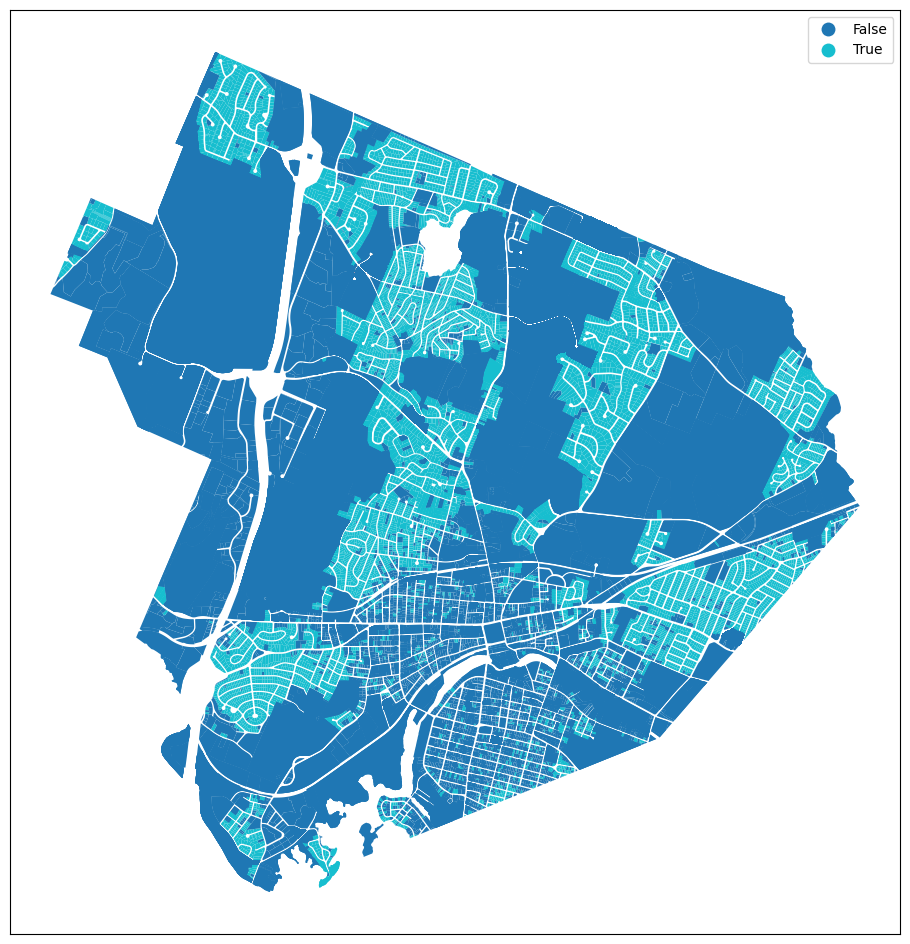

In [4]:
df["IS_SFH"] = df["USE_CODE"].apply(lambda x: x == "101")
ax = df.plot(column="IS_SFH", legend=True, aspect=1, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [5]:
print(f"number of SFH homes in Waltham: {len(df[df['IS_SFH']])}")

number of SFH homes in Waltham: 9533


## Diving into the regulations

The section of our zoning code describing the regulations for ADUs can be found at the link below:

https://ecode360.com/13128595#13128572

Already in the first part of the first full sentence we're off to a bad start - the Board of Appeals must grant a special permit to allow an ADU. No way for there to be a by-right development by outlining
a clear set of rules and ministerial approval that the rules were followed to the letter. This is discouraging enough on its own.

Most of the regulations aren't really something that can be checked easily via GIS, so this analysis will just look at the criteria below.

## (b)

_The dwelling unit is accessory to the principal residence and either the dwelling unit or the principal residence is occupied by the owner of the lot on which the dwelling unit is to be located, which owner shall have owned the lot for not less than five years._

This is the kind of owner occupancy clause that the state law is specifically forbidding. It's just nonsense - why must the owner reside on the lot? And why a five year minimum residency requirement?

We don't have a foolproof way of checking residency, so we'll go with our current method of 'matching a lot of characters' in the owner address on the tax records matching the site address.

In [6]:
df["IS_OWNER_OCCUPIED_SFH"] = df.apply(lambda row: row["OWNER_OCCUPIED"] and row["IS_SFH"], axis=1)

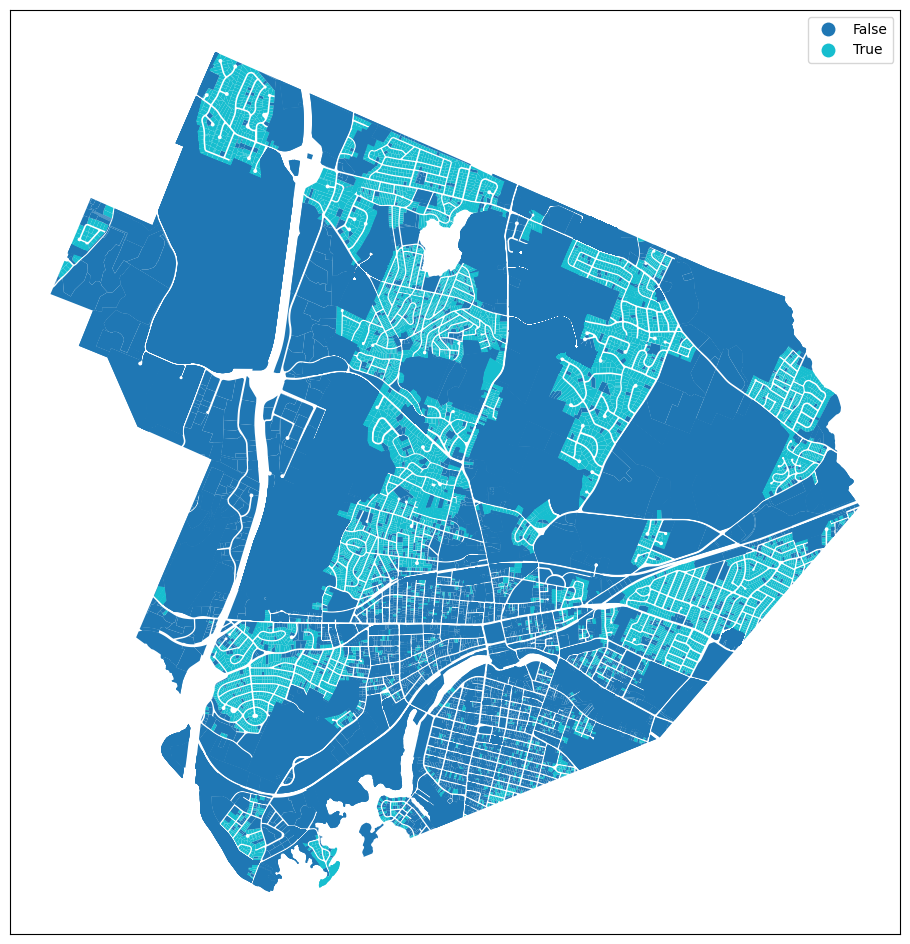

In [7]:
ax = df.plot(column="IS_OWNER_OCCUPIED_SFH", legend=True, aspect=1, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [8]:
print(f"number of owner occupied SFH homes in Waltham: {len(df[df['IS_OWNER_OCCUPIED_SFH']])}")

number of owner occupied SFH homes in Waltham: 9008


This doesn't seem to be a big blocker on its own, in Waltham at least. It gets worse though.

## (h)

_The lot on which the dwelling is located contains at least 20,000 square feet in Residence A-1 Districts and 15,000 square feet in Residence A-2 Districts._

This doesn't specify anything else about the other districts. Should we take this at its most restrictive interpretation, that ADUs are only allowed in A1 and A2?

In [9]:
def lot_conforms(row):
    zone = row["NAME"]
    if zone not in ["RA1", "RA2"] or not row["IS_OWNER_OCCUPIED_SFH"]:
        return False
    
    if zone == "RA1":
        return row["LOT_SIZE"] >= 20_000
    else:
        return row["LOT_SIZE"] >= 15_000


df["IS_LOT_SIZE_CONFORMING"] = df.apply(lambda row: lot_conforms(row), axis=1)

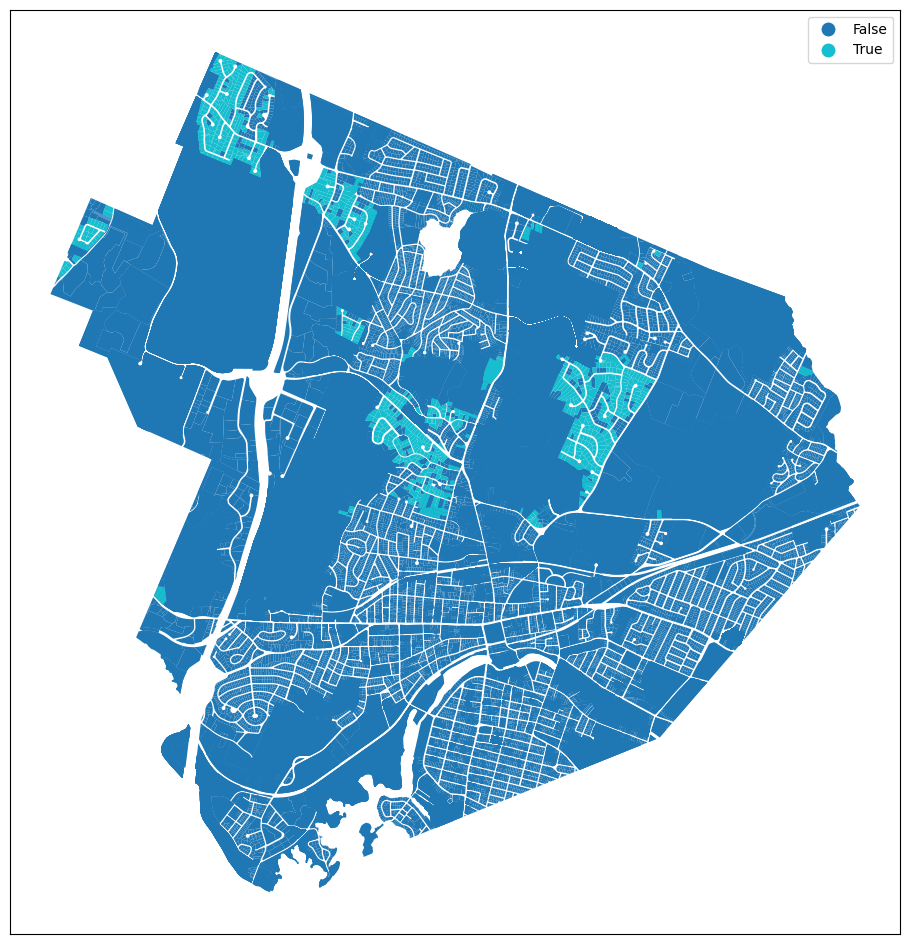

In [10]:
ax = df.plot(column="IS_LOT_SIZE_CONFORMING", legend=True, aspect=1, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [17]:
print(f"has a conforming lot size: {len(df[df['IS_LOT_SIZE_CONFORMING']])}")

has a conforming lot size: 867


## (i)

_The building in which the proposed dwelling unit is to be located existed on the date of the adoption of this subsection._

This is quite prohibitive in my interpretation - it seems to suggest you can't build new structures and convert them to ADUs.

I think one might find this [here](https://ecode360.com/29869836) but it's not really clear when this section was added. It could be the 1988 renumbering of sections 
(which is listed as 'All' sections in this table), but it was probably added earlier and just not amended.

Fortunately, this was done at the end of 1988 so we just have to check outbuildings (I think only detached structures are permitted) built before 1989.

In [14]:
# TODO: I'm not 100% sure about this join
df_buildings = buildings_df.sjoin(df, how="right", predicate="within")

In [15]:
def is_preexisting_outbldg(row):
    if not row["IS_LOT_SIZE_CONFORMING"]:
        return False
    
    if row["YearBuilt"] >= 1989:
        return False

    return True


df_buildings["IS_PREXEXISTING_OUTBLDG"] = df_buildings.apply(lambda row: is_preexisting_outbldg(row), axis=1)

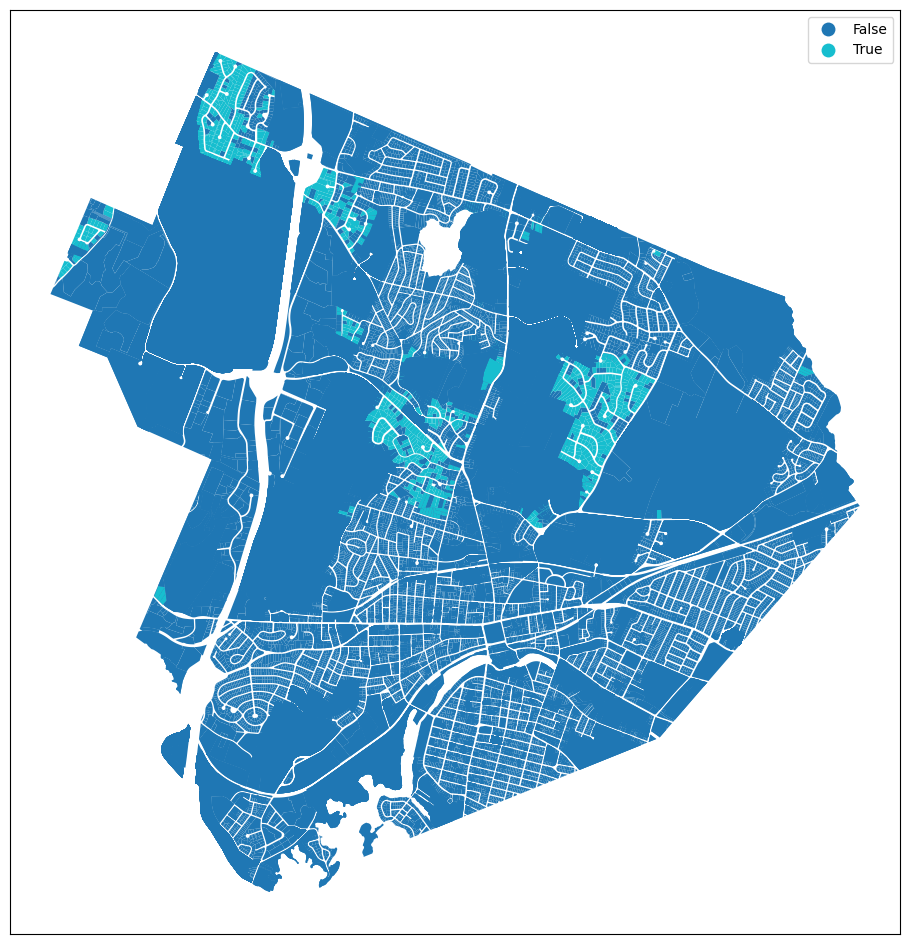

In [16]:
ax = df_buildings.plot(column="IS_PREXEXISTING_OUTBLDG", legend=True, aspect=1, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [19]:
print(f"has a pre-existing out building: {len(df_buildings[df_buildings['IS_PREXEXISTING_OUTBLDG']])}")

has a pre-existing out building: 863
